# Correclation Matrix

- Imported code for making correlation matrixes
- Can be ran in notebook for the result files or in the command line
- This tests and shows the code for the new result files and one will in the future be adjusted to use on the Norkyst model

In [6]:
from corr_matrix import plot_corr

['latitude', 'longitude', 'salinity_0', 'temperature_0', 'u_eastward_0', 'v_northward_0', 'zeta']
All other variables removed. The variables dropped are: ['latitude', 'longitude']
                             salinity_0  temperature_0  ...  v_northward_0  zeta
X   Y   time                                            ...                     
0.0 0.0 2024-05-02 00:00:00         NaN            NaN  ...       0.000000   NaN
        2024-05-02 03:00:00         NaN            NaN  ...       0.000394   NaN
        2024-05-02 06:00:00         NaN            NaN  ...      -0.003251   NaN
        2024-05-02 09:00:00         NaN            NaN  ...      -0.004885   NaN
        2024-05-02 12:00:00         NaN            NaN  ...      -0.005084   NaN

[5 rows x 5 columns]


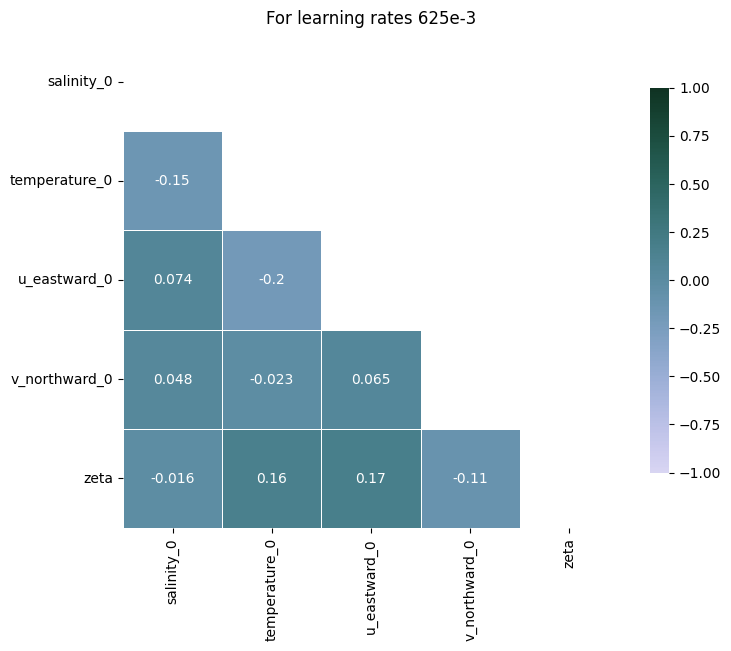

In [9]:
plot_corr('/lustre/storeB/project/fou/hi/foccus/experiments/learning_rate/625e-3/inference/625_2d.nc', 'For learning rates 625e-3')